In [1]:
import os

from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents import Document
from langchain_google_vertexai import VertexAIEmbeddings
from langchain_mongodb import MongoDBAtlasVectorSearch
from langchain_text_splitters import RecursiveCharacterTextSplitter
from pymongo import MongoClient

load_dotenv()
os.getenv("MONGODB_DATABASE")

'mongodb_docs_bot'

In [2]:
# Ensure your VertexAI credentials are configured

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash-001", model_provider="google_vertexai")
embeddings = VertexAIEmbeddings(model="text-embedding-004")

In [3]:
MONGODB_URI = os.getenv("MONGODB_URI")
MONGODB_DATABASE = os.getenv("MONGODB_DATABASE")

prefix = "loader_explorations"

client = MongoClient(MONGODB_URI)
collection = client[MONGODB_DATABASE][prefix]

vector_store = MongoDBAtlasVectorSearch(
    embedding=embeddings,
    collection=collection,
    index_name=prefix,
    relevance_score_fn="cosine",
)

In [4]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=(
        "https://www.mongodb.com/docs/atlas/reference/atlas-limits/",
        "https://www.mongodb.com/docs/atlas/reference/flex-limitations/",
        "https://www.mongodb.com/docs/atlas/reference/free-shared-limitations/",
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
vector_1 = embeddings.embed_query(all_splits[0].page_content)
vector_2 = embeddings.embed_query(all_splits[1].page_content)

assert len(vector_1) == len(vector_2)
print(f"Generated vectors of length {len(vector_1)}\n")

Generated vectors of length 768



In [6]:
# vector_store.create_vector_search_index(dimensions=len(vector_1))
# _ = vector_store.add_documents(documents=all_splits)

In [7]:
results = vector_store.similarity_search_with_score(
    "What is the limit of organizations per Atlas user?"
)
doc, score = results[0]
print(f"Score: {score}\n")
print(doc)

Score: 0.8526841998100281

page_content='cluster, the performance of a cluster might degrade if it serves a large
number of collections and indexes. Larger collections have a greater
impact on performance.The recommended maximum combined number of collections and indexes by
Atlas cluster tier are as follows:Cluster tierRecommended maximumM105,000 collections and indexesM20 / M3010,000 collections and indexesM40+100,000 collections and indexesIncrease Collection and Index LimitsIf you need to increase the number of collections or indexes in your Atlas
cluster, consider upgrading your cluster tier.Organization and Project LimitsComponentLimitDatabase Users per
Atlas Project100Atlas Users per
Atlas Project500Atlas Users per
Atlas Organization500API Keys per Atlas Organization500Access List Entries per
Atlas Project200Users per Atlas Team250Teams per Atlas Project100Teams per Atlas Organization250Teams per Atlas User100Organizations per Atlas User250Linked Organizations per' metadata={'_id

In [8]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


/Users/charlie.xu/code/mongodb_docs_bot/venv/lib/python3.12/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [9]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

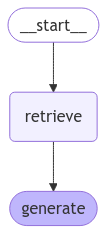

In [10]:
from IPython.display import Image, display
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
result = graph.invoke(
    {"question": "What is the limit of organizations per Atlas user?"}
)

print(f'Answer: {result["answer"]}')
print(f'Context: {result["context"]}\n\n')

Answer: The limit of organizations per Atlas user is 250. This is according to the Atlas Service Limits documentation. The documentation also lists limits for other components like projects, teams and API keys.

Context: [Document(metadata={'_id': '67c282bd355d0d848e15f326', 'source': 'https://www.mongodb.com/docs/atlas/reference/atlas-limits/', 'title': 'Atlas Service Limits - MongoDB Atlas - MongoDB Docs', 'language': 'en'}, page_content='cluster, the performance of a cluster might degrade if it serves a large\nnumber of collections and indexes. Larger collections have a greater\nimpact on performance.The recommended maximum combined number of collections and indexes by\nAtlas cluster tier are as follows:Cluster tierRecommended maximumM105,000 collections and indexesM20 / M3010,000 collections and indexesM40+100,000 collections and indexesIncrease Collection and Index LimitsIf you need to increase the number of collections or indexes in your Atlas\ncluster, consider upgrading your cl

In [12]:
client.close()